In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emnist-letters-mapping.txt
/kaggle/input/emnist-letters-test.csv
/kaggle/input/emnist-mnist-mapping.txt
/kaggle/input/emnist-digits-train.csv
/kaggle/input/emnist-bymerge-mapping.txt
/kaggle/input/emnist-balanced-train.csv
/kaggle/input/emnist-digits-test.csv
/kaggle/input/emnist-balanced-test.csv
/kaggle/input/emnist-mnist-test.csv
/kaggle/input/emnist-letters-train.csv
/kaggle/input/emnist-byclass-train.csv
/kaggle/input/emnist-bymerge-test.csv
/kaggle/input/emnist-balanced-mapping.txt
/kaggle/input/emnist-mnist-train.csv
/kaggle/input/emnist-digits-mapping.txt
/kaggle/input/emnist-bymerge-train.csv
/kaggle/input/emnist-byclass-test.csv
/kaggle/input/emnist-byclass-mapping.txt
/kaggle/input/emnist_source_files/emnist-digits-test-labels-idx1-ubyte
/kaggle/input/emnist_source_files/emnist-bymerge-train-labels-idx1-ubyte
/kaggle/input/emnist_source_files/emnist-letters-test-labels-idx1-ubyte
/kaggle/input/emnist_source_files/emnist-byclass-train-images-idx3-ubyte
/kaggle/i

In [2]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import time


In [3]:
# Load the balanced training dataset
balanced_train = pd.read_csv("../input/emnist-balanced-train.csv")
# Load the balanced testing dataset
balanced_test = pd.read_csv("../input/emnist-balanced-test.csv")
# Load the mapping
mapp = pd.read_csv("../input/emnist-balanced-mapping.txt", delimiter=' ', index_col=0, header=None)

In [4]:
#printing shapes 
print(f"""
Train: {balanced_train.shape}
Test:  {balanced_test.shape}
Map:   {mapp.shape}
""")


Train: (112799, 785)
Test:  (18799, 785)
Map:   (47, 1)



In [5]:
# Create keys as integers from 0 to the length of the mapping values
keys = range(len(mapp[1].values)) 

# Convert the integer values to corresponding characters using ASCII
values = [chr(v) for v in mapp[1].values]

# Create a dictionary mapping integers to characters
map_dict = dict(zip(keys, values))
map_dict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

In [6]:
#splliting target coloumn and features from train and test dataset
#training
X_train = np.array(balanced_train.iloc[:,1:].values)
y_train = np.array(balanced_train.iloc[:,0].values)

#testing
X_test = np.array(balanced_test.iloc[:,1:].values)
y_test = np.array(balanced_test.iloc[:,0].values)

print(f"x_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (112799, 784)
y_train: (112799,)
x_test: (18799, 784)
y_test: (18799,)


In [7]:
#displaying the no of classes
column_name = '45'
if column_name in balanced_train.columns:
    classes = len(balanced_train[column_name].unique())
    print(f"number of classes  : {classes}") 
else:
    print(f"Column '{column_name}' not found in the DataFrame.")

number of classes  : 47


In [8]:
#storing no of classes in classes variable for input size for output layers
classes = len(balanced_train['45'].unique()) 
print('number of classes : ', classes) 

number of classes :  47


In [9]:
def rotate_emnist(x_data):
    
    x_data = x_data.reshape(x_data.shape[0], 28, 28)
    x_data = np.transpose(x_data,(0,2,1))
    
    return(x_data)

X_train = rotate_emnist(X_train)
X_test = rotate_emnist(X_test)

In [10]:
# Normalise and reshape data
X_train = X_train.astype('float32')  / 255.0
X_test = X_test.astype('float32')  / 255.0

In [11]:
# One hot encoding
y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)
print(f"x_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (112799, 28, 28)
y_train: (112799, 47)
x_test: (18799, 28, 28)
y_test: (18799, 47)


# Create the MLP+CNN Model

In [12]:
X_train = X_train.reshape(-1,28,28,1)
X_test  = X_test.reshape(-1,28,28,1)

print("x_train : ",X_train.shape)
print("y_train : ",y_train.shape)
print("x_test  : ",X_test.shape)
print("y_test  : ",y_test.shape)

x_train :  (112799, 28, 28, 1)
y_train :  (112799, 47)
x_test  :  (18799, 28, 28, 1)
y_test  :  (18799, 47)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout

# Define the model
model0 = Sequential()

# Convolutional Layer
model0.add(Conv2D(filters=4, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))

# Flatten the output from the convolutional layer
model0.add(Flatten())

# Fully connected layer
model0.add(Dense(32, activation='relu'))
model0.add(Dropout(0.3))

# Output layer
model0.add(Dense(47, activation='softmax'))

# Compile the model
model0.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model0.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 4)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        86,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │         1,551 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,151 (344.34 KB)

 Trainable params: 88,151 (344.34 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

if os.path.exists("Best_points.keras"):
    os.remove("Best_points.keras")

MCP = ModelCheckpoint('Best_points.keras', verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')

In [15]:
batch_size  = 64
epochs      = 80

start_time0 = time.time()
history0 = model0.fit(  X_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      
                      validation_data = (X_test, y_test),callbacks=MCP)
stop_time0 = time.time()

# Calculate elapsed time
elapsed_time0 = stop_time0 - start_time0
minutes0 = int(elapsed_time0 // 60)
seconds0 = int(elapsed_time0 % 60)

# Print time used in minutes and seconds
print(f'training_time0 = {minutes0} min {seconds0} sec')

Epoch 1/80


I0000 00:00:1733375456.790620     133 service.cc:145] XLA service 0x7ab7b40066e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733375456.790670     133 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733375456.790674     133 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 116/1763 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0304 - loss: 3.8473

I0000 00:00:1733375459.586953     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1763/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1814 - loss: 3.1768
Epoch 1: val_accuracy improved from -inf to 0.58344, saving model to Best_points.keras
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.1814 - loss: 3.1764 - val_accuracy: 0.5834 - val_loss: 1.5874
Epoch 2/80
1731/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4567 - loss: 1.9293
Epoch 2: val_accuracy improved from 0.58344 to 0.63668, saving model to Best_points.keras
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4570 - loss: 1.9280 - val_accuracy: 0.6367 - val_loss: 1.3217
Epoch 3/80
1731/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5090 - loss: 1.6907
Epoch 3: val_accuracy improved from 0.63668 to 0.66184, saving model to Best_points.keras
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5092 - loss: 1.6901 - val_accuracy: 0.6618 - val_loss: 1.2012
Epoch 4/80
1745/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5390 - loss: 1.5787
Epoch 4: val_accuracy improved from

In [16]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model('Best_points.keras')

# Evaluate the model on the test dataset
score = best_model.evaluate(X_test, y_test, verbose=0)

# Print the evaluation results
print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.5738
Test accuracy : 0.8219


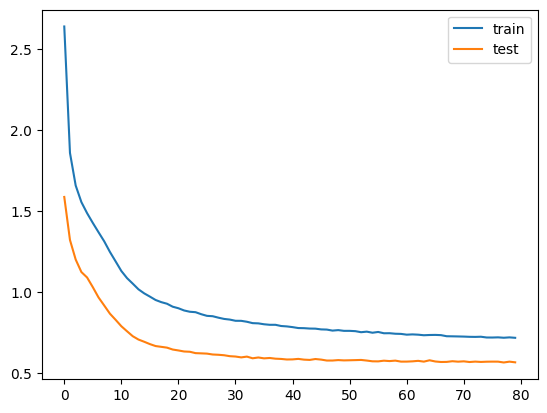

In [17]:
plt.plot(history0.history['loss'], label='train')
plt.plot(history0.history['val_loss'], label='test')
plt.legend()

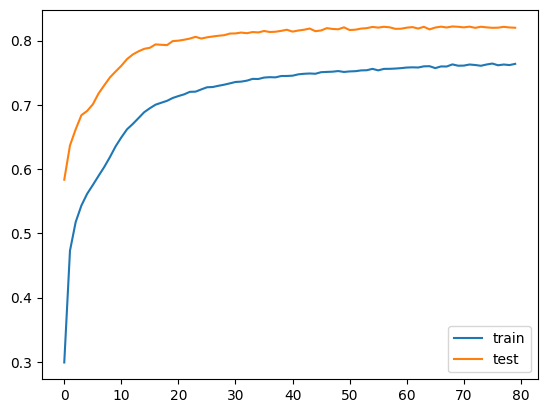

In [18]:
plt.plot(history0.history['accuracy'], label='train')
plt.plot(history0.history['val_accuracy'], label='test')
plt.legend()

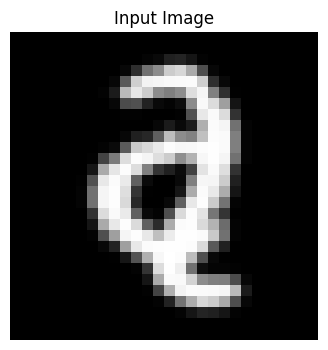

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


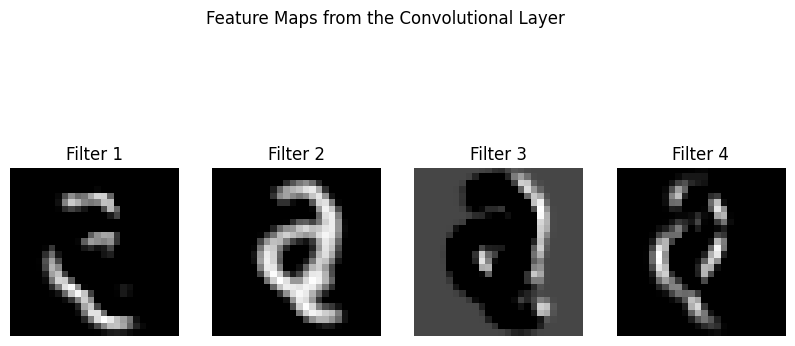

In [19]:
import matplotlib.pyplot as plt
from keras.models import Model

# Choose an image from the dataset
image = X_train[0]  # Select the first training image
image = image.reshape(1, 28, 28, 1)  # Add batch dimension

# Display the original input image
plt.figure(figsize=(4, 4))
plt.imshow(image[0, :, :, 0], cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.show()

# Define a new model to output feature maps of the convolutional layers
input_tensor = model0.layers[0].input

layer_outputs = [layer.output for layer in model0.layers if 'conv' in layer.name]
feature_map_model = Model(inputs=input_tensor, outputs=layer_outputs)

# Get feature maps for the selected image
feature_maps = feature_map_model.predict(image)

# Visualize the feature maps (4 filters only)
plt.figure(figsize=(10, 5))  # Adjust size for 4 filters
for i in range(4):  # Since there are only 4 filters
    plt.subplot(1, 4, i + 1)  # Arrange filters in a row
    plt.imshow(feature_maps[0, :, :, i], cmap='gray')  # Display each filter's output
    plt.title(f"Filter {i + 1}")
    plt.axis('off')
plt.suptitle("Feature Maps from the Convolutional Layer")
plt.show()